## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [25]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
# %matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)

# cv2.destroyAllWindows()

## And so on and so forth...

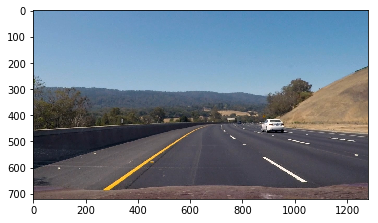

In [31]:
import matplotlib.image as mpimg
%matplotlib inline
#Read in an image
img = mpimg.imread("../test_images/test3.jpg")
plt.imshow(img)

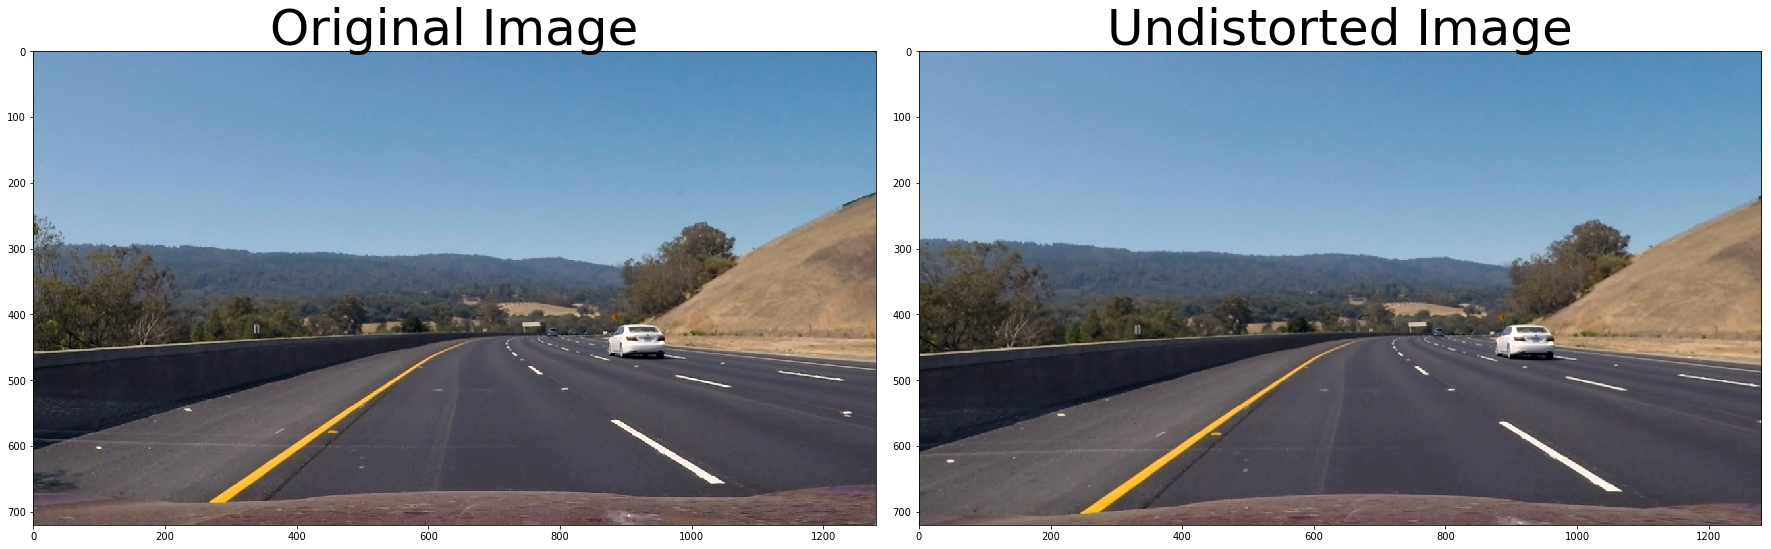

In [32]:
def cal_undistort(img, objpoints, imgpoints):
    undist = np.copy(img)
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,\
    imgpoints, gray.shape[::-1],None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist

# undistorted =  cal_undistort(img, objpoints, imgpoints)


undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1,2, figsize = (24,9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.)

In [33]:
vertices = np.array([[(0.15*undistorted.shape[1],undistorted.shape[0]),(0.93*undistorted.shape[1],undistorted.shape[0]),
                      (0.61*undistorted.shape[1],undistorted.shape[0]*0.63),(0.465*undistorted.shape[1],undistorted.shape[0]*0.63)]],
                   np.int32)

# vertices = np.array([[(0.15*undistorted.shape[1],undistorted.shape[0]),(0.87*undistorted.shape[1],undistorted.shape[0]),
#                   (0.55*undistorted.shape[1],undistorted.shape[0]*0.63),(0.455*undistorted.shape[1],undistorted.shape[0]*0.63)]],
#                np.int32)
pts = vertices.reshape((-1,1,2))
# cv2.polylines(undistorted,[pts],True,(255,0,0),3);



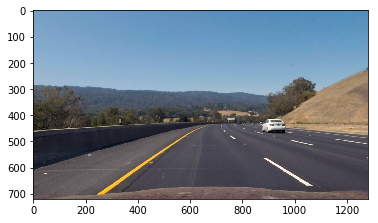

In [34]:
plt.imshow(undistorted)

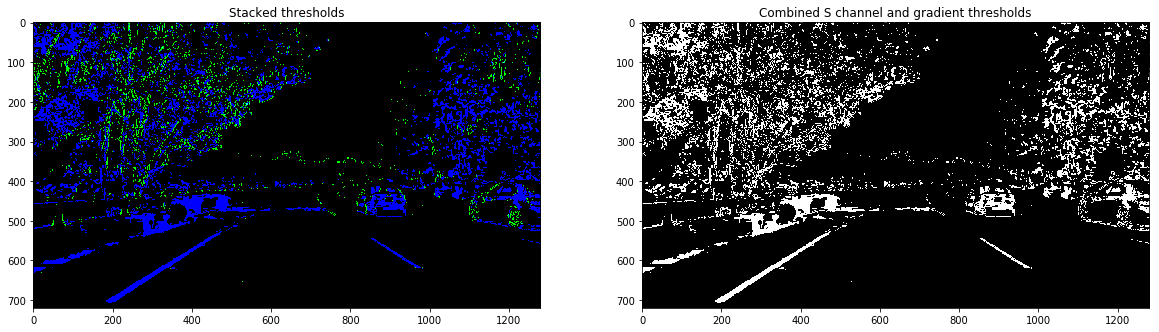

In [1044]:
img = undistorted
# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 50
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 140
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

In [23]:
def warp(img):
    
    ## Define calibration box in source (original) and destination(desired or warped)
    ## coordinate
    
    img_size = (img.shape[1], img.shape[0])
    
    # Four source coordinates
    vertices = np.array([[(0.15*undistorted.shape[1],undistorted.shape[0]),(0.87*undistorted.shape[1],undistorted.shape[0]),
                      (0.55*undistorted.shape[1],undistorted.shape[0]*0.63),(0.455*undistorted.shape[1],undistorted.shape[0]*0.63)]],
                   np.int32)
#     vertices = np.array([[(0.15*undistorted.shape[1],undistorted.shape[0]),(0.93*undistorted.shape[1],undistorted.shape[0]),
#                       (0.63*undistorted.shape[1],undistorted.shape[0]*0.69),(0.4*undistorted.shape[1],undistorted.shape[0]*0.69)]],
#                    np.int32)
#     vertices = np.array([[(0.15*undistorted.shape[1],undistorted.shape[0]),(0.93*undistorted.shape[1],undistorted.shape[0]),
#                       (0.61*undistorted.shape[1],undistorted.shape[0]*0.63),(0.465*undistorted.shape[1],undistorted.shape[0]*0.63)]],
#                    np.int32)
    src = np.float32(vertices)
    
    # Four desired coordinate
    
    
    vertices = np.array([[(0.15*undistorted.shape[1],undistorted.shape[0]),(0.87*undistorted.shape[1],undistorted.shape[0]),
                      (0.87*undistorted.shape[1],0),(0.15*undistorted.shape[1],0)]],
                   np.int32)
    dst = np.float32(vertices)
    
    # Compute the perspective transforms, M
    M = cv2.getPerspectiveTransform(src,dst)
    
    # Could compute the inverse also by swapping the input parameters
    Minv = cv2.getPerspectiveTransform(dst,src)
    
    # Create warped image - usese linear interpolation
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped,Minv
    

In [1046]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [39]:
wraped,o = warp(undistorted)
wraped = np.array(wraped)
plt.imsave("../img_readme/color_wraped.jpg", wraped)

In [ ]:
plt.imsave(wraped,"")

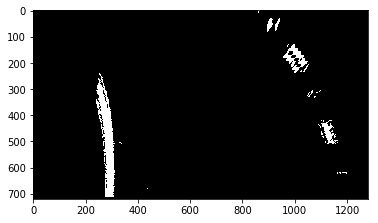

In [1013]:
# f_out = region_of_interest(combined_binary,vertices)
# wraped = warp(f_out)
# plt.imshow(wraped, cmap = "gray")

In [1091]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis = 0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack([binary_warped]*3)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Hyperparameter
    # Choose the number of sliding windows
    nwindows = 9
    # Choose the number of sliding windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Set height of windows -  based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all non zero pixel in the image 
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current position to be updated later for each window in nwindows 
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices 
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # TO-DO: Find the four below boundaries of the window 
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the window on the visualization image 
        cv2.rectangle(out_img, (win_xleft_low, win_y_low),
                      (win_xleft_high, win_y_high), (0,255,0),2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), 
                     (win_xright_high, win_y_high), (0,255,0),2)
        
        # TO-DO: Identify the nonzero pixels in the x ad y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        #Append these indicies to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If we found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    ## Concatenate the arrays of indicies (previously was a list of lists)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass

    # Extract left and right line pixel position
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, rightx, righty, out_img

def fit_polynomial(binary_warped,Minv,undist):
    # Find our lane pixels first
    
    leftx, lefty, rightx, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        
#     ## Visualization ##
#     # Colors in the left and right lane regions
#     out_img[lefty, leftx] = [255, 0, 0]
#     out_img[righty, rightx] = [0, 0, 255]

#     # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
    # Create an image to draw the line on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero,warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx,ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx,ploty])))])
    pts= np.hstack((pts_left,pts_right))
    
    #Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))
    #Warp the blank back to original image space using inverse perspective 
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1],binary_warped.shape[0]))
    
    result = cv2.addWeighted(undist, 1, newwarp,0.3,0)
    

    return result

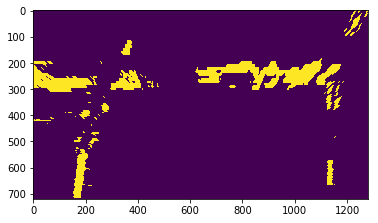

In [1068]:
plt.imshow(wraped)

In [1069]:
out_img = fit_polynomial(wraped)
plt.imshow(out_img)

NameError: name 'Mniv' is not defined

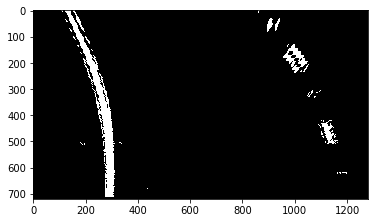

In [1019]:
plt.imshow(wraped,cmap="gray")

In [4]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [1107]:
def process_img(image):
    img = cal_undistort(image,objpoints,imgpoints)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 50
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 140
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
#     color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

#     # Plotting thresholded images
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
#     ax1.set_title('Stacked thresholds')
#     ax1.imshow(color_binary)

#     ax2.set_title('Combined S channel and gradient thresholds')
#     ax2.imshow(combined_binary, cmap='gray')
    warped,Minv = warp(combined_binary)
    vertices = np.array([[(0.15*undistorted.shape[1],undistorted.shape[0]),(0.93*undistorted.shape[1],undistorted.shape[0]),
                      (0.61*undistorted.shape[1],undistorted.shape[0]*0.63),(0.465*undistorted.shape[1],undistorted.shape[0]*0.63)]],
                   np.int32)
    out = fit_polynomial(warped,Minv,img)
    
    return out



    
    
    
    
    

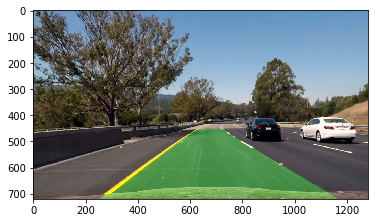

In [1108]:
img = mpimg.imread("../test_images/test6.jpg")
out = process_img(img)
plt.imshow(out)

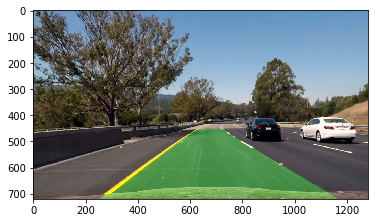

In [1104]:
out_img = fit_polynomial(out,Minv,undist)
plt.imshow(out_img)

In [17]:
class Lines:
    def __init__(self,objpoints,imgpoints):
        self.objpoints = objpoints
        self.imgpoints = imgpoints
        self.left_fit = [None]
        self.right_fit = [None]
        
    
        
    def fit_polynomial(self,binary_warped,Minv,undist):
        # Find our lane pixels first
        if self.left_fit[0] == None:
            leftx, lefty, rightx, rightx, righty = self.find_lane_pixels(binary_warped)
            

            # Fit a second order polynomial to each using `np.polyfit`
            self.left_fit = np.polyfit(lefty,leftx,2)
            self.right_fit = np.polyfit(righty, rightx, 2)

            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            try:
                left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
                right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]
            except TypeError:
                # Avoids an error if `left` and `right_fit` are still none or incorrect
                print('The function failed to fit a line!')
                left_fitx = 1*ploty**2 + 1*ploty
                right_fitx = 1*ploty**2 + 1*ploty
        else:
            left_fitx,right_fitx = self.search_around_poly(binary_warped)
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    #     ## Visualization ##
    #     # Colors in the left and right lane regions
    #     out_img[lefty, leftx] = [255, 0, 0]
    #     out_img[righty, rightx] = [0, 0, 255]

    #     # Plots the left and right polynomials on the lane lines
    #     plt.plot(left_fitx, ploty, color='yellow')
    #     plt.plot(right_fitx, ploty, color='yellow')
        # Create an image to draw the line on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero,warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx,ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx,ploty])))])
        pts= np.hstack((pts_left,pts_right))

        #Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))
        #Warp the blank back to original image space using inverse perspective 
        newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1],binary_warped.shape[0]))

        result = cv2.addWeighted(undist, 1, newwarp,0.3,0)


        return result
    def find_lane_pixels(self,binary_warped):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis = 0)
        # Create an output image to draw on and visualize the result
#         out_img = np.dstack([binary_warped]*3)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Hyperparameter
        # Choose the number of sliding windows
        nwindows = 9
        # Choose the number of sliding windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Set height of windows -  based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all non zero pixel in the image 
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current position to be updated later for each window in nwindows 
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices 
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            # TO-DO: Find the four below boundaries of the window 
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
#             # Draw the window on the visualization image 
#             cv2.rectangle(out_img, (win_xleft_low, win_y_low),
#                           (win_xleft_high, win_y_high), (0,255,0),2)
#             cv2.rectangle(out_img, (win_xright_low, win_y_low), 
#                          (win_xright_high, win_y_high), (0,255,0),2)

            # TO-DO: Identify the nonzero pixels in the x ad y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

            #Append these indicies to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If we found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        ## Concatenate the arrays of indicies (previously was a list of lists)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            pass

        # Extract left and right line pixel position
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        return leftx, lefty, rightx, rightx, righty
    
    def process_img(self,image,type_=True):
        img = self.cal_undistort(image,self.objpoints,self.imgpoints)
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]

        # Grayscale image
        # NOTE: we already saw that standard grayscaling lost color information for the lane lines
        # Explore gradients in other colors spaces / color channels to see what might work better
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Sobel x
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

        # Threshold x gradient
        thresh_min =50
        thresh_max = 100
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

        # Threshold color channel
        s_thresh_min = 140
        s_thresh_max = 255
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

        # Stack each channel to view their individual contributions in green and blue respectively
        # This returns a stack of the two binary images, whose components you can see as different colors
    #     color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

        # Combine the two binary thresholds
        combined_binary = np.zeros_like(sxbinary)
        combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
        vertices = np.array([[(0.15*combined_binary.shape[1],combined_binary.shape[0]),(0.93*combined_binary.shape[1],combined_binary.shape[0]),
                  (0.61*combined_binary.shape[1],combined_binary.shape[0]*0.63),(0.465*combined_binary.shape[1],combined_binary.shape[0]*0.63)]],
               np.int32)

#         combined_binary = self.region_of_interest(combined_binary,vertices)

    #     # Plotting thresholded images
    #     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    #     ax1.set_title('Stacked thresholds')
    #     ax1.imshow(color_binary)

    #     ax2.set_title('Combined S channel and gradient thresholds')
    #     ax2.imshow(combined_binary, cmap='gray')
        
        warped,Minv = self.warp(combined_binary)

#         plt.imshow(img2)

#         out = self.fit_polynomial(warped,Minv,img)
        if type_ :
            out = self.fit_polynomial(warped,Minv,img)
            vertices = np.array([[(0.15*img.shape[1],img.shape[0]),(0.87*img.shape[1],img.shape[0]),
                  (0.55*img.shape[1],img.shape[0]*0.63),(0.455*img.shape[1],img.shape[0]*0.63)]],
               np.int32)
            vertices = np.array([[(0.12*img.shape[1],img.shape[0]),(0.87*img.shape[1],img.shape[0]),
                      (0.55*img.shape[1],img.shape[0]*0.63),(0.43*img.shape[1],img.shape[0]*0.63)]],
                   np.int32)
            pts = vertices.reshape((-1,1,2))
#             cv2.polylines(out,[pts],True,(255,0,0),3);
        else:
            
            out = np.dstack(( warped, warped, warped)) * 255
#         
#         cv2.polylines(out,[pts],True,(255,0,0),3);
    

        return out
    def fit_poly(self,img_shape, leftx, lefty, rightx, righty):
        # To do: fit a second order polynomial to each of the line
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        self.left_fit = self.left_fit*0.3 + 0.7*left_fit
        self.right_fit = self.right_fit*0.3 + 0.7*right_fit

        # Generate x and valuse for plotting
        ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
        # Calculate both polynomials using ploty, left_fit and right_fit
        left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]

        return left_fitx, right_fitx, ploty
    def search_around_poly(self,binary_warped):
        ## HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        # The quiz grader expects 100 here, but feel free to tune on your own!

        margin = 100

        # This little tricky and useful
        # Grab activated pixel
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        ## To-do: Set the area of search based on activated x-values
        ## within the +/- margin of our polynomial function
        left_lane_ids = ((nonzerox > (self.left_fit[0]*(nonzeroy**2)+ self.left_fit[1]*nonzeroy + 
                                     self.left_fit[2])-margin) & (nonzerox < (self.left_fit[0]*(nonzeroy**2)+ self.left_fit[1]*nonzeroy + 
                                     self.left_fit[2])+margin))
        right_lane_ids = ((nonzerox > (self.right_fit[0]*(nonzeroy**2)+ self.right_fit[1]*nonzeroy + 
                                     self.right_fit[2])-margin) & (nonzerox < (self.right_fit[0]*(nonzeroy**2)+ self.right_fit[1]*nonzeroy + 
                                     self.right_fit[2])+margin))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_ids]
        lefty = nonzeroy[left_lane_ids]
        rightx  = nonzerox[right_lane_ids]
        righty = nonzeroy[right_lane_ids]

        # Fit new polynomial 
        left_fitx, right_fitx, ploty = self.fit_poly(binary_warped.shape, leftx, lefty,
                                                rightx, righty)

        return left_fitx,right_fitx
    def warp(self,img):
    
        ## Define calibration box in source (original) and destination(desired or warped)
        ## coordinate

        img_size = (img.shape[1], img.shape[0])

        # Four source coordinates
        vertices = np.array([[(0.12*img.shape[1],img.shape[0]),(0.87*img.shape[1],img.shape[0]),
                          (0.55*img.shape[1],img.shape[0]*0.63),(0.43*img.shape[1],img.shape[0]*0.63)]],
                       np.int32)
        vertices = np.array([[(0.15*img.shape[1],img.shape[0]),(0.87*img.shape[1],img.shape[0]),
                  (0.55*img.shape[1],img.shape[0]*0.63),(0.455*img.shape[1],img.shape[0]*0.63)]],
               np.int32)
#         vertices = np.array([[(0.15*img.shape[1],img.shape[0]),(0.87*img.shape[1],img.shape[0]),
#                   (0.55*img.shape[1],img.shape[0]*0.63),(0.455*img.shape[1],img.shape[0]*0.63)]],
#                np.int32
    #     vertices = np.array([[(0.15*undistorted.shape[1],undistorted.shape[0]),(0.93*undistorted.shape[1],undistorted.shape[0]),
    #                       (0.63*undistorted.shape[1],undistorted.shape[0]*0.69),(0.4*undistorted.shape[1],undistorted.shape[0]*0.69)]],
    #                    np.int32)
    #     vertices = np.array([[(0.15*undistorted.shape[1],undistorted.shape[0]),(0.93*undistorted.shape[1],undistorted.shape[0]),
    #                       (0.61*undistorted.shape[1],undistorted.shape[0]*0.63),(0.465*undistorted.shape[1],undistorted.shape[0]*0.63)]],
    #                    np.int32)
        src = np.float32(vertices)

        # Four desired coordinate


        vertices = np.array([[(0.15*img.shape[1],img.shape[0]),(0.87*img.shape[1],img.shape[0]),
                          (0.87*img.shape[1],0),(0.15*img.shape[1],0)]],
                       np.int32)
        dst = np.float32(vertices)

        # Compute the perspective transforms, M
        M = cv2.getPerspectiveTransform(src,dst)

        # Could compute the inverse also by swapping the input parameters
        Minv = cv2.getPerspectiveTransform(dst,src)

        # Create warped image - usese linear interpolation
        warped = cv2.warpPerspective(img, M, img_size)

        return warped,Minv
    def cal_undistort(self,img, objpoints, imgpoints):
        undist = np.copy(img)
        gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,\
        imgpoints, gray.shape[::-1],None,None)
        undist = cv2.undistort(img, mtx, dist, None, mtx)

        return undist
    def region_of_interest(self,img, vertices):
        """
        Applies an image mask.

        Only keeps the region of the image defined by the polygon
        formed from `vertices`. The rest of the image is set to black.
        `vertices` should be a numpy array of integer points.
        """
        #defining a blank mask to start with
        mask = np.zeros_like(img)   

        #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255

        #filling pixels inside the polygon defined by "vertices" with the fill color    
        cv2.fillPoly(mask, vertices, ignore_mask_color)

        #returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image





In [35]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # To do: fit a second order polynomial to each of the line
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and valuse for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calculate both polynomials using ploty, left_fit and right_fit
    left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
    right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]
    
    return left_fitx, right_fitx, ploty


def search_around_poly(self,binary_warped):
    ## HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    
    margin = 120
    
    # This little tricky and useful
    # Grab activated pixel
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ## To-do: Set the area of search based on activated x-values
    ## within the +/- margin of our polynomial function
    left_lane_ids = ((nonzerox > (self.left_fit[0]*(nonzeroy**2)+ self.left_fit[1]*nonzeroy + 
                                 self.left_fit[2])-margin) & (nonzerox < (self.left_fit[0]*(nonzeroy**2)+ self.left_fit[1]*nonzeroy + 
                                 self.left_fit[2])+margin))
    right_lane_ids = ((nonzerox > (self.right_fit[0]*(nonzeroy**2)+ self.right_fit[1]*nonzeroy + 
                                 self.right_fit[2])-margin) & (nonzerox < (self.right_fit[0]*(nonzeroy**2)+ self.right_fit[1]*nonzeroy + 
                                 self.right_fit[2])+margin))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_ids]
    lefty = nonzeroy[left_lane_ids]
    rightx  = nonzerox[right_lane_ids]
    righty = nonzeroy[right_lane_ids]
    
    # Fit new polynomial 
    left_fitx, right_fitx, ploty = self.fit_poly(binary_warped.shape, leftx, lefty,
                                            rightx, righty)
    
    return left_fitx,right_fitx

    
    
    

In [18]:
line = Lines(objpoints,imgpoints)

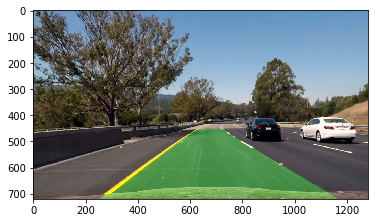

In [6]:
line = Lines(objpoints,imgpoints)
img = mpimg.imread("../test_images/test6.jpg")
out = line.process_img(img,True)
plt.imshow(out)

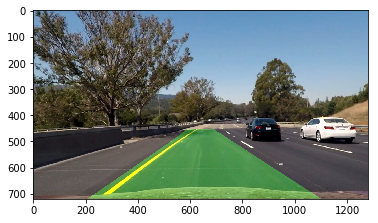

In [144]:
img = mpimg.imread("../test_images/test6.jpg")
out = line.process_img(img,True)
plt.imshow(out)

In [19]:
line = Lines(objpoints,imgpoints)

In [20]:
video_out = "../output_images/pilotTest.mp4"

clip = VideoFileClip("../project_video.mp4")
out_clip = clip.fl_image(line.process_img)
%time out_clip.write_videofile(video_out, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video ../output_images/pilotTest.mp4.
Moviepy - Writing video ../output_images/pilotTest.mp4



Moviepy - Done !
Moviepy - video ready ../output_images/pilotTest.mp4
CPU times: user 26min 31s, sys: 47.4 s, total: 27min 18s
Wall time: 24min 2s


In [21]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_out))